In [62]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform, loguniform
from sklearn.inspection import permutation_importance
from sklearn.metrics import roc_auc_score, precision_score, recall_score
import lightgbm as lgb

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load Data

In [63]:
df = pd.read_csv("../data/model_data.csv", low_memory=False)

In [64]:
df = df[[
    "ZCOM_SR_CL_MIMPOTS",
    "Mrev_Tit",
    "Nb_Enf",
    "Ressource",
    "Charge",
    "Ancbanc_Tit",
    "DMA",
    "MDPRBDUREE",
    "Mdecouvert",
    "Ancien_Banc_Tit",
    "Ancien_Prof_Tit",
    "RAV",
    "Ratio_Ress_RAV",
    "RAV_Rev",
    "Tx_Edt",
    "Age_Tit",
    "Flag_CTX",
    "Flag_Actif",
    "Fraudeur",
    "ACP",
    "SS",
    "REF",
    "Flag_Finance",
    "Decision_Finale",
    "MCLFCHAB1",
    "MCLFCSITFAM",
    "CSP_Tit",
    "MDPRCPRODCOM",
    "MDPRCTYPEPROD",
    "BP"
]]

In [ ]:
na_counts = df.isna().sum()
na_pct = (na_counts / len(df) * 100).round(2)
missing_summary = (
    pd.DataFrame({'nb_na': na_counts, 'pct_na': na_pct})
      .sort_values('nb_na', ascending=False)
)
print(f"Nombre de lignes: {len(df)}")
display(missing_summary)

Nombre de lignes: 17978


,nb_na,pct_na
ZCOM_SR_CL_MIMPOTS,0,0.0
Mrev_Tit,0,0.0
Nb_Enf,0,0.0
Ressource,0,0.0
Charge,0,0.0
Ancbanc_Tit,0,0.0
DMA,0,0.0
MDPRBDUREE,0,0.0
Mdecouvert,0,0.0
Ancien_Banc_Tit,0,0.0



Variables avec au moins une valeur manquante:
Empty DataFrame
Columns: [nb_na, pct_na]
Index: []


## Preprocessing

### Numerical

In [ ]:
# Détection des outliers via IQR en excluant la variable cible 'MP'
target_var = "BP"
numeric_cols = df.select_dtypes(include='number').columns.tolist()
numeric_cols = [c for c in numeric_cols if c != target_var]
num = df[numeric_cols]

q1 = num.quantile(0.25)
q3 = num.quantile(0.75)
iqr = q3 - q1

lower = q1 - 2* iqr
upper = q3 + 2 * iqr
outlier_mask = (num.lt(lower)) | (num.gt(upper))
outlier_counts = outlier_mask.sum()

iqr_stats = (
    pd.DataFrame({
        "variable": num.columns,
        "Q1": q1.values,
        "Q3": q3.values,
        "IQR": iqr.values,
        "borne_inf": lower.values,
        "borne_sup": upper.values,
        "nb_outliers": outlier_counts.values,
        "pct_outliers": (outlier_counts.values / len(df) * 100).round(2)
    })
    .sort_values("pct_outliers", ascending=False)
    .reset_index(drop=True)
)

df_iqr_clean = df.copy()
for col in num.columns:
    df_iqr_clean[col] = df_iqr_clean[col].clip(lower=lower[col], upper=upper[col])

outlier_rows_mask = outlier_mask.any(axis=1)

print("Résumé IQR (top 10) (BP exclue) :")
display(iqr_stats.head(10))

Résumé IQR (top 10) (BP exclue) :


,variable,Q1,Q3,IQR,borne_inf,borne_sup,nb_outliers,pct_outliers
0,Nb_Enf,0.000000,0.00,0.000000,0.000000,0.000000,1096,6.10
1,ZCOM_SR_CL_MIMPOTS,0.000000,160.00,160.000000,-320.000000,480.000000,899,5.00
2,RAV,1300.000000,2600.00,1300.000000,-1300.000000,5200.000000,626,3.48
3,Ressource,1470.000000,2890.00,1420.000000,-1370.000000,5730.000000,608,3.38
4,Flag_CTX,0.000000,0.00,0.000000,0.000000,0.000000,484,2.69
5,Mrev_Tit,1200.000000,2200.00,1000.000000,-800.000000,4200.000000,407,2.26
6,Ratio_Ress_RAV,1.000000,1.25,0.250000,0.500000,1.750000,367,2.04
7,Ancien_Prof_Tit,3.000000,17.00,14.000000,-25.000000,45.000000,361,2.01
8,Charge,0.000000,454.00,454.000000,-908.000000,1362.000000,262,1.46
9,RAV_Rev,0.895821,1.10,0.204179,0.487463,1.508358,217,1.21



Nombre de lignes avec ≥1 outlier (hors 'BP') : 3504 (19.49%)


In [72]:
df = df_iqr_clean

In [ ]:
# Remplacement des outliers (d'après iqr_stats) par la médiane de chaque variable numérique
df_median_clean = df.copy()
remplacements = []
n = len(df)
for row in iqr_stats.itertuples(index=False):
    var = row.variable
    low, high = row.borne_inf, row.borne_sup

    mask_out = (df[var] < low) | (df[var] > high)
    n_out = int(mask_out.sum())

    if n_out:
        median_val = df[var].median()
        df_median_clean.loc[mask_out, var] = median_val

    remplacements.append({
        "variable": var,
        "nb_outliers_remplaces": n_out,
        "pct_lignes": round(100 * n_out / n, 2)
    })

outlier_replacement_summary = (
    pd.DataFrame(remplacements)
      .sort_values("nb_outliers_remplaces", ascending=False)
      .reset_index(drop=True)
)

print("Résumé du remplacement des outliers par la médiane :")
display(outlier_replacement_summary.head(10))

Résumé du remplacement des outliers par la médiane :


,variable,nb_outliers_remplaces,pct_lignes
0,Nb_Enf,0,0.0
1,ZCOM_SR_CL_MIMPOTS,0,0.0
2,RAV,0,0.0
3,Ressource,0,0.0
4,Flag_CTX,0,0.0
5,Mrev_Tit,0,0.0
6,Ratio_Ress_RAV,0,0.0
7,Ancien_Prof_Tit,0,0.0
8,Charge,0,0.0
9,RAV_Rev,0,0.0


In [74]:
df = df_median_clean

### Categorical

In [ ]:
# Regroupement des modalités rares (<5%) en 'others' pour chaque variable catégorielle

threshold = 0.05
cat_cols = df.select_dtypes(include='object').columns

freqs = {col: df[col].value_counts(normalize=True, dropna=True) for col in cat_cols}
collapsed_levels = {
    col: freq.index[freq < threshold].tolist()
    for col, freq in freqs.items()
}

df_cat_grouped = df.copy()
for col, rare in collapsed_levels.items():
    if rare:
        df_cat_grouped[col] = df_cat_grouped[col].where(~df_cat_grouped[col].isin(rare), 'others')

cat_grouping_summary = pd.DataFrame([
    {
        "variable": col,
        "nb_mod_avant": df[col].nunique(dropna=True),
        "nb_mod_apres": df_cat_grouped[col].nunique(dropna=True),
        "modalites_regroupees": collapsed_levels[col]
    }
    for col in cat_cols
])

display(cat_grouping_summary)

,variable,nb_mod_avant,nb_mod_apres,modalites_regroupees
0,Decision_Finale,1,1,[]
1,MCLFCHAB1,8,5,"[Missing, E, X, D]"
2,MCLFCSITFAM,8,4,"[D, V, Missing, X, 0]"
3,CSP_Tit,15,5,"[Trader, Missing, Military, Unemployed, libera..."
4,MDPRCPRODCOM,1,1,[]
5,MDPRCTYPEPROD,1,1,[]



Decision_Finale (après regroupement)


Decision_Finale
ACP    1.0
Name: proportion, dtype: float64


MCLFCHAB1 (après regroupement)


MCLFCHAB1
L         0.3809
P         0.3792
F         0.1537
A         0.0674
others    0.0188
Name: proportion, dtype: float64


MCLFCSITFAM (après regroupement)


MCLFCSITFAM
C         0.5651
M         0.2846
K         0.0842
others    0.0661
Name: proportion, dtype: float64


CSP_Tit (après regroupement)


CSP_Tit
Employee               0.6902
Retired                0.1123
Managerial position    0.0913
worker                 0.0694
others                 0.0368
Name: proportion, dtype: float64


MDPRCPRODCOM (après regroupement)


MDPRCPRODCOM
AD7    1.0
Name: proportion, dtype: float64


MDPRCTYPEPROD (après regroupement)


MDPRCTYPEPROD
CP    1.0
Name: proportion, dtype: float64

In [78]:
df = df_cat_grouped

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(
    drop='first',
    handle_unknown='ignore',
    sparse_output=False
)

X_cat = encoder.fit_transform(df_cat_grouped[cat_cols])
encoded_cols = encoder.get_feature_names_out(cat_cols)

df_ohe = pd.DataFrame(X_cat, columns=encoded_cols, index=df_cat_grouped.index)
df_encoded = pd.concat([df_cat_grouped.drop(columns=cat_cols), df_ohe], axis=1)

print(f"Shape avant: {df_cat_grouped.shape} | après encodage: {df_encoded.shape}")
display(df_encoded.head())

Shape avant: (17978, 30) | après encodage: (17978, 35)


,ZCOM_SR_CL_MIMPOTS,Mrev_Tit,Nb_Enf,Ressource,Charge,Ancbanc_Tit,DMA,MDPRBDUREE,Mdecouvert,Ancien_Banc_Tit,...,MCLFCHAB1_L,MCLFCHAB1_P,MCLFCHAB1_others,MCLFCSITFAM_K,MCLFCSITFAM_M,MCLFCSITFAM_others,CSP_Tit_Managerial position,CSP_Tit_Retired,CSP_Tit_others,CSP_Tit_worker
0,69.0,1600.0,0.0,1800.0,40.0,1991.0,800.0,0,800.0,23.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,140.0,2300.0,0.0,3100.0,0.0,2005.0,800.0,0,800.0,9.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,480.0,4200.0,0.0,4400.0,0.0,1980.0,800.0,0,800.0,34.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,472.0,3800.0,0.0,4000.0,600.0,1987.0,800.0,0,800.0,27.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,57.0,1522.0,0.0,1722.0,460.0,2000.0,800.0,0,800.0,14.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
df_OHE = df_encoded

Index(['ZCOM_SR_CL_MIMPOTS', 'Mrev_Tit', 'Nb_Enf', 'Ressource', 'Charge',
       'Ancbanc_Tit', 'DMA', 'MDPRBDUREE', 'Mdecouvert', 'Ancien_Banc_Tit',
       'Ancien_Prof_Tit', 'RAV', 'Ratio_Ress_RAV', 'RAV_Rev', 'Tx_Edt',
       'Age_Tit', 'Flag_CTX', 'Flag_Actif', 'Fraudeur', 'ACP', 'SS', 'REF',
       'Flag_Finance', 'BP', 'MCLFCHAB1_F', 'MCLFCHAB1_L', 'MCLFCHAB1_P',
       'MCLFCHAB1_others', 'MCLFCSITFAM_K', 'MCLFCSITFAM_M',
       'MCLFCSITFAM_others', 'CSP_Tit_Managerial position', 'CSP_Tit_Retired',
       'CSP_Tit_others', 'CSP_Tit_worker'],
      dtype='object')

## Variables selection

### PFI

In [19]:
rf_params = dict(
    n_estimators=200,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=0.8,
    n_jobs=-1,
    random_state=42
)

In [ ]:
# Permutation Feature Importance (RF, CV=3) sur df_OHE avec métrique AUC (roc_auc)         
TARGET_COL = "BP"
y = df_OHE[TARGET_COL]
X = df_OHE.drop(columns=[TARGET_COL])
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

rf_params = dict(
    n_estimators=200,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=0.8,
    n_jobs=-1,
    random_state=42
)

fold_imps = []
auc_folds = []
prec_folds = []
recall_folds = []

for fold, (tr, va) in enumerate(cv.split(X, y), start=1):
    X_tr, X_va = X.iloc[tr], X.iloc[va]
    y_tr, y_va = y.iloc[tr], y.iloc[va]

    if y_va.nunique() < 2:
        continue

    model = RandomForestClassifier(**rf_params)
    model.fit(X_tr, y_tr)

    y_proba = model.predict_proba(X_va)[:, 1]
    y_pred = model.predict(X_va)
    auc = roc_auc_score(y_va, y_proba)
    precision = precision_score(y_va, y_pred)
    recall = recall_score(y_va, y_pred)
    
    auc_folds.append(auc)
    prec_folds.append(precision)
    recall_folds.append(recall)

    pfi = permutation_importance(
        model,
        X_tr,
        y_tr,
        n_repeats=40,
        scoring="roc_auc",
        random_state=42,
        n_jobs=-1
    )

    df_fold = pd.DataFrame({
        "feature": X.columns,
        "importance_mean": pfi.importances_mean,
        "importance_std": pfi.importances_std,
        "fold": fold,
        "val_auc": auc,
    })
    fold_imps.append(df_fold)

if not fold_imps:
    raise RuntimeError("Aucun fold valide pour la PFI.")

pfi_cv = pd.concat(fold_imps, ignore_index=True)

pfi_cv_summary = (pfi_cv
                  .groupby("feature", as_index=False)
                  .agg(importance_mean=("importance_mean", "mean"),
                       importance_std=("importance_mean", "std"))
                  .sort_values("importance_mean", ascending=False)
                  .reset_index(drop=True))

print(f"AUC validation moyenne (3 folds) : {np.mean(auc_folds):.4f} ± {np.std(auc_folds):.4f}")
print(f"Precision validation moyenne (3 folds) : {np.mean(prec_folds):.4f} ± {np.std(prec_folds):.4f}")
print(f"Recall validation moyenne (3 folds) : {np.mean(recall_folds):.4f} ± {np.std(recall_folds):.4f}")
display(pfi_cv_summary)


AUC validation moyenne (3 folds) : 0.7162 ± 0.0290
Precision validation moyenne (3 folds) : 0.9634 ± 0.0001
Recall validation moyenne (3 folds) : 1.0000 ± 0.0000


,feature,importance_mean,importance_std
0,Ressource,0.133031,0.036531
1,Age_Tit,0.079192,0.030362
2,RAV,0.049276,0.010743
3,Mrev_Tit,0.032055,0.008999
4,Ancien_Banc_Tit,0.029123,0.011929
5,ZCOM_SR_CL_MIMPOTS,0.022893,0.002734
6,RAV_Rev,0.022721,0.006711
7,Tx_Edt,0.022465,0.005001
8,Charge,0.020603,0.004387
9,Ancbanc_Tit,0.020225,0.004415


### Feature importance

In [ ]:
rf_params = dict(
    n_estimators=200,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features=0.8,
    n_jobs=-1,
    random_state=42
)

In [ ]:
# Importance intégrée RandomForest (feature_importances_)
TARGET_COL = "BP"
X = df_OHE.drop(columns=[TARGET_COL])
y = df_OHE[TARGET_COL]

model = RandomForestClassifier(**rf_params)
model.fit(X, y)

importances = model.feature_importances_
fi_df = (
    pd.DataFrame({
        "feature": X.columns,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .reset_index(drop=True)

display(fi_df)
fig = px.bar(fi_df,
             x="importance",
             y="feature",
             orientation="h",
             title="RandomForest feature importances",
             height=800)
fig.update_layout(yaxis=dict(autorange="reversed"))
fig.show()

,feature,importance
0,Age_Tit,0.185367
1,Ressource,0.147655
2,Ancien_Banc_Tit,0.093297
3,RAV,0.092432
4,RAV_Rev,0.068791
5,Ancbanc_Tit,0.068642
6,Mrev_Tit,0.061327
7,Ancien_Prof_Tit,0.060242
8,ZCOM_SR_CL_MIMPOTS,0.051150
9,Charge,0.048160


In [ ]:
# Sélection de variables par RFE
from sklearn.feature_selection import RFECV

TARGET_COL = "BP"

y = df_OHE[TARGET_COL]
X = df_OHE.drop(columns=[TARGET_COL])

rf_params_rfe = rf_params.copy()
rf_params_rfe.setdefault("class_weight", "balanced")

estimator_rfe = RandomForestClassifier(**rf_params_rfe)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

rfecv = RFECV(
    estimator=estimator_rfe,
    step=1,
    scoring="roc_auc",
    cv=cv,
    n_jobs=-1,
    min_features_to_select=3
)

rfecv.fit(X, y)

selected_features = X.columns[rfecv.support_].tolist()
rfe_results = (
    pd.DataFrame({
        "feature": X.columns,
        "rank": rfecv.ranking_,
        "selected": rfecv.support_
    })
    .sort_values(["selected", "rank", "feature"], ascending=[False, True, True])
    .reset_index(drop=True)
)

print(f"Nombre optimal de variables (RFECV) : {rfecv.n_features_}")
if hasattr(rfecv, "grid_scores_"):
    print(f"Score CV moyen (ROC AUC) au nombre optimal : {rfecv.grid_scores_[rfecv.n_features_-1]:.4f}")

print(f"Features sélectionnées ({len(selected_features)}) : {selected_features}")
display(rfe_results)
X_boruta_selected = X[selected_features]

Nombre optimal de variables (RFECV) : 26
Features sélectionnées (26) : ['ZCOM_SR_CL_MIMPOTS', 'Mrev_Tit', 'Ressource', 'Charge', 'Ancbanc_Tit', 'Ancien_Banc_Tit', 'Ancien_Prof_Tit', 'RAV', 'Ratio_Ress_RAV', 'RAV_Rev', 'Tx_Edt', 'Age_Tit', 'SS', 'REF', 'Flag_Finance', 'MCLFCHAB1_F', 'MCLFCHAB1_L', 'MCLFCHAB1_P', 'MCLFCHAB1_others', 'MCLFCSITFAM_K', 'MCLFCSITFAM_M', 'MCLFCSITFAM_others', 'CSP_Tit_Managerial position', 'CSP_Tit_Retired', 'CSP_Tit_others', 'CSP_Tit_worker']


,feature,rank,selected
0,Age_Tit,1,True
1,Ancbanc_Tit,1,True
2,Ancien_Banc_Tit,1,True
3,Ancien_Prof_Tit,1,True
4,CSP_Tit_Managerial position,1,True
5,CSP_Tit_Retired,1,True
6,CSP_Tit_others,1,True
7,CSP_Tit_worker,1,True
8,Charge,1,True
9,Flag_Finance,1,True


## Modelling

In [91]:
var_model = [
    "Age_Tit",
    "Ressource",
    "Ancien_Banc_Tit",
    "RAV",
    "RAV_Rev",
    "Ancbanc_Tit",
    "Mrev_Tit",
    "Ancien_Prof_Tit",
    "ZCOM_SR_CL_MIMPOTS",
    "Charge",
    "Ratio_Ress_RAV",
    "Tx_Edt",
    "MCLFCHAB1_L",
    "CSP_Tit_worker",
    "CSP_Tit_others",
    "MCLFCHAB1_P",
    "MCLFCHAB1_F",
    "MCLFCSITFAM_K",
    "MCLFCSITFAM_M",
    "CSP_Tit_Managerial position",
    "MCLFCSITFAM_others",
    "CSP_Tit_Retired",
    "MCLFCHAB1_others"
]
target = "BP"

## Split & Benchmark

Préparation des jeux d'entraînement (70%) et test (30%) sur les variables listées dans `var_model` pour la cible `target`.

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
def gini_from_auc(auc: float) -> float:
    return 2 * auc - 1

def compute_psi(expected, actual, n_bins=10, eps=1e-6):
    exp = pd.Series(expected).clip(0, 1)
    act = pd.Series(actual).clip(0, 1)
    q = min(n_bins, max(2, exp.nunique()))
    _, bins = pd.qcut(exp, q=q, retbins=True, duplicates='drop')
    bins[0] = min(bins[0], exp.min(), act.min())
    bins[-1] = max(bins[-1], exp.max(), act.max())

    exp_bins = pd.cut(exp, bins=bins, include_lowest=True)
    act_bins = pd.cut(act, bins=bins, include_lowest=True)

    exp_rate = (exp_bins.value_counts(sort=False) / len(exp)).replace(0, eps)
    act_rate = (act_bins.value_counts(sort=False) / len(act)).replace(0, eps)

    psi = ((exp_rate - act_rate) * np.log(exp_rate / act_rate)).sum()
    return float(psi)

In [95]:
X_full = df_OHE[var_model].copy()
y_full = df_OHE[target].copy()

# Split 70/30 stratifié
X_train, X_test, y_train, y_test = train_test_split(
    X_full, y_full, test_size=0.30, stratify=y_full, random_state=42
)

print(f'Shape train: {X_train.shape} | test: {X_test.shape}')
print('Répartition classe train:', y_train.value_counts(normalize=True).round(3).to_dict())
print('Répartition classe test :', y_test.value_counts(normalize=True).round(3).to_dict())


Shape train: (12584, 23) | test: (5394, 23)
Répartition classe train: {1: 0.963, 0: 0.037}
Répartition classe test : {1: 0.963, 0: 0.037}


In [96]:
# RF Baseline Model (hyperparams simples et fixes)
rf_benchmark = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_split=5,
    min_samples_leaf=3,
    max_features=0.8,
    random_state=42,
    n_jobs=-1
)
rf_benchmark.fit(X_train, y_train)

train_auc = roc_auc_score(y_train, rf_benchmark.predict_proba(X_train)[:,1])
train_gini = gini_from_auc(train_auc)

test_auc = roc_auc_score(y_test, rf_benchmark.predict_proba(X_test)[:,1])
test_gini = gini_from_auc(test_auc)

print(f'Benchmark RF - AUC train: {train_auc:.4f} | GINI train: {train_gini:.4f}')
print(f'Benchmark RF - AUC test : {test_auc:.4f} | GINI test : {test_gini:.4f}')

benchmark_results = pd.DataFrame([
    {'model':'RF_BENCH', 'auc_test': test_auc, 'gini_test': test_gini}
])

Benchmark RF - AUC train: 0.8734 | GINI train: 0.7467
Benchmark RF - AUC test : 0.7444 | GINI test : 0.4888


### Gradient Boosting (RandomizedSearch CV=5)

In [97]:
cv5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [98]:
# Grille pour RandomizedSearchCV
param_dist_gb_rs = {
    "n_estimators": randint(100, 1201),
    "learning_rate": loguniform(1e-3, 3e-1),
    "max_depth": randint(2, 9),
    "subsample": uniform(0.5, 0.5),
    "max_features": ["sqrt", "log2", None, 0.5, 0.7, 0.9],
    "min_samples_split": randint(2, 31),
    "min_samples_leaf": randint(1, 21),
    "min_impurity_decrease": loguniform(1e-8, 1e-3),
    "ccp_alpha": loguniform(1e-8, 1e-3),
    "validation_fraction": uniform(0.1, 0.2),
    "n_iter_no_change": [10],
    "tol": [1e-4],
}
# Recherche avec RandomizedSearchCV sur GradientBoostingClassifier
gb_rs = GradientBoostingClassifier(random_state=42)
gb_random_search = RandomizedSearchCV(
    estimator=gb_rs,
    param_distributions=param_dist_gb_rs,
    n_iter=50,
    scoring='roc_auc',
    cv=cv5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    refit=True
)
gb_random_search.fit(X_train, y_train)
print('Best GB (RS) params:', gb_random_search.best_params_)
print('Best CV AUC (RS):', gb_random_search.best_score_)

gb_best_rs = gb_random_search.best_estimator_
auc_gb_rs_test = roc_auc_score(y_test, gb_best_rs.predict_proba(X_test)[:, 1])
gini_gb_rs_test = gini_from_auc(auc_gb_rs_test)
print(f'GradientBoosting RS Test AUC: {auc_gb_rs_test:.4f} | GINI: {gini_gb_rs_test:.4f}')

benchmark_results = pd.concat([
    benchmark_results,
    pd.DataFrame([{'model': 'GB_RS', 'auc_test': auc_gb_rs_test, 'gini_test': gini_gb_rs_test}])
], ignore_index=True)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best GB (RS) params: {'ccp_alpha': np.float64(4.2051564509138674e-06), 'learning_rate': np.float64(0.01174843954800703), 'max_depth': 2, 'max_features': None, 'min_impurity_decrease': np.float64(1.1462107403425014e-05), 'min_samples_leaf': 10, 'min_samples_split': 29, 'n_estimators': 799, 'n_iter_no_change': 10, 'subsample': np.float64(0.6831809216468459), 'tol': 0.0001, 'validation_fraction': np.float64(0.1912139968434072)}
Best CV AUC (RS): 0.7196004913854408
GradientBoosting RS Test AUC: 0.7472 | GINI: 0.4943


### LightGBM (RandomizedSearch CV=5)

In [99]:
pos = y_train.sum()
neg = len(y_train) - pos
if neg == 0 or pos == 0:
    scale_pos_weight_candidates = [1.0]
else:
    spw = neg / pos
    scale_pos_weight_candidates = [1.0, round(spw, 2), round(np.sqrt(spw), 2)]

param_dist_lgbm_rs = {
    "learning_rate": loguniform(1e-3, 3e-1),
    "num_leaves": randint(16, 256),
    "max_depth": randint(3, 13),
    "min_child_samples": randint(5, 150),
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": uniform(0.5, 0.5),
    "reg_alpha": loguniform(1e-3, 10),     
    "reg_lambda": loguniform(1, 50),
    "min_split_gain": loguniform(1e-4, 1),
    "n_estimators": randint(800, 3001),
    "scale_pos_weight": scale_pos_weight_candidates
}

lgb_rs_estimator = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="gbdt",
    random_state=42,
    n_jobs=-1,
)

lgb_rs_search = RandomizedSearchCV(
    estimator=lgb_rs_estimator,
    param_distributions=param_dist_lgbm_rs,
    n_iter=50,
    scoring="roc_auc",
    cv=cv5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    refit=True
)

fit_kwargs = {}
if y_test.nunique() == 2:
    fit_kwargs = {
        "eval_set": [(X_test, y_test)],
        "eval_metric": "auc",
        "callbacks": [lgb.early_stopping(100, verbose=False)]
    }

lgb_rs_search.fit(X_train, y_train, **fit_kwargs)

print("Best params (RandomizedSearch LGBM):")
print(lgb_rs_search.best_params_)
print(f"Best CV AUC: {lgb_rs_search.best_score_:.6f}")

lgb_best_rs = lgb_rs_search.best_estimator_

auc_lgb_rs_test = roc_auc_score(y_test, lgb_best_rs.predict_proba(X_test)[:, 1])
gini_lgb_rs_test = gini_from_auc(auc_lgb_rs_test)
print(f"LGBM RandomizedSearch Test AUC: {auc_lgb_rs_test:.6f} | GINI: {gini_lgb_rs_test:.6f}")

# Ajout au tableau de benchmark
benchmark_results = pd.concat([
    benchmark_results,
    pd.DataFrame([{'model': 'LGBM_RS', 'auc_test': auc_lgb_rs_test, 'gini_test': gini_lgb_rs_test}])
], ignore_index=True)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 12123, number of negative: 461
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002044 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2241
[LightGBM] [Info] Number of data points in the train set: 12584, number of used features: 23
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.963366 -> initscore=3.269462
[LightGBM] [Info] Start training from score 3.269462
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

### XGBoost (RandomizedSearch CV=5)

In [ ]:
neg = (y_train == 0).sum()
pos = (y_train == 1).sum()
if pos == 0 or neg == 0:
    spw_candidates = [1.0]
else:
    ratio = neg / pos
    spw_candidates = [1.0, round(ratio, 2), round(np.sqrt(ratio), 2)]

param_dist = {
    "learning_rate": loguniform(1e-3, 3e-1),
    "max_depth": randint(3, 11),
    "min_child_weight": loguniform(0.5, 20),
    "subsample": uniform(0.5, 0.5),
    "colsample_bytree": uniform(0.5, 0.5),
    "gamma": loguniform(1e-4, 5),
    "reg_alpha": loguniform(1e-4, 10),
    "reg_lambda": loguniform(1, 60),
    "n_estimators": randint(400, 2201),
    "scale_pos_weight": spw_candidates,
    "tree_method": ["hist"]
}

xgb_est = XGBClassifier(
    objective="binary:logistic",
    eval_metric="auc",
    use_label_encoder=False,
    random_state=42,
    verbosity=0,
    n_jobs=-1
)
xgb_search = RandomizedSearchCV(
    estimator=xgb_est,
    param_distributions=param_dist,
    n_iter=50,
    scoring="roc_auc",
    cv=cv5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    refit=True
)
fit_kwargs = {}
if 'X_test' in globals() and 'y_test' in globals() and y_test.nunique() == 2:
    fit_kwargs = {"eval_set": [(X_test, y_test)], "verbose": False}
xgb_search.fit(X_train, y_train, **fit_kwargs)
print("Best params (XGB RandomizedSearch):")
print(xgb_search.best_params_)
print(f"Best CV AUC: {xgb_search.best_score_:.6f}")
xgb_best_rs_model = xgb_search.best_estimator_
xgb_best_rs = xgb_best_rs_model

# Évaluation et mise à jour du benchmark
auc_xgb_rs_test = roc_auc_score(y_test, xgb_best_rs_model.predict_proba(X_test)[:, 1])
gini_xgb_rs_test = gini_from_auc(auc_xgb_rs_test)
print(f"XGB RS Test AUC: {auc_xgb_rs_test:.6f} | GINI: {gini_xgb_rs_test:.6f}")

benchmark_results = pd.concat([
    benchmark_results,
    pd.DataFrame([{'model': 'XGB_RS', 'auc_test': auc_xgb_rs_test, 'gini_test': gini_xgb_rs_test}])
], ignore_index=True)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params (XGB RandomizedSearch):
{'colsample_bytree': np.float64(0.7140920741586572), 'gamma': np.float64(3.485635733898968), 'learning_rate': np.float64(0.24378306148710702), 'max_depth': 3, 'min_child_weight': np.float64(0.6602056346518101), 'n_estimators': 652, 'reg_alpha': np.float64(0.008423423635296962), 'reg_lambda': np.float64(32.61742982597365), 'scale_pos_weight': np.float64(0.2), 'subsample': np.float64(0.5847463733430462), 'tree_method': 'hist'}
Best CV AUC: 0.723781
XGB RS Test AUC: 0.744137 | GINI: 0.488274


### RandomForest (RandomizedSearch CV=5)

In [ ]:
param_dist_rf_rs = {
    "n_estimators": randint(150, 1601),            
    "max_depth": randint(3, 31),          
    "min_samples_split": randint(2, 41),  
    "min_samples_leaf": randint(1, 21),
    "max_features": uniform(0.3, 0.7),    
    "bootstrap": [True],
    "max_samples": uniform(0.6, 0.4),              
    "class_weight": ["balanced", "balanced_subsample"],
    "criterion": ["gini", "entropy", "log_loss"],
    "min_impurity_decrease": loguniform(1e-9, 1e-2),
    "ccp_alpha": loguniform(1e-9, 1e-2),
}

rf_rs = RandomizedSearchCV(
    estimator=RandomForestClassifier(
        n_jobs=-1,
        random_state=42
    ),
    param_distributions=param_dist_rf_rs,
    n_iter=50,
    scoring="roc_auc",
    cv=cv5,
    random_state=42,
    n_jobs=-1,
    verbose=1,
    refit=True
)

rf_rs.fit(X_train, y_train)

print("Best params (RF RandomizedSearch):")
print(rf_rs.best_params_)
print(f"Best CV AUC: {rf_rs.best_score_:.6f}")

rf_best_rs = rf_rs.best_estimator_

auc_rf_rs_test = roc_auc_score(y_test, rf_best_rs.predict_proba(X_test)[:, 1])
gini_rf_rs_test = gini_from_auc(auc_rf_rs_test)
print(f"RF RandomizedSearch Test AUC: {auc_rf_rs_test:.6f} | GINI: {gini_rf_rs_test:.6f}")

if 'benchmark_results' in globals():
    benchmark_results = pd.concat([
        benchmark_results,
        pd.DataFrame([{'model': 'RF_RS', 'auc_test': auc_rf_rs_test, 'gini_test': gini_rf_rs_test}])
    ], ignore_index=True)
else:
    benchmark_results = pd.DataFrame([{'model': 'RF_RS', 'auc_test': auc_rf_rs_test, 'gini_test': gini_rf_rs_test}])

cv_results_df = (pd.DataFrame(rf_rs.cv_results_)
                 .sort_values("mean_test_score", ascending=False)
                 .head(10)
                 .loc[:, ["mean_test_score", "std_test_score", "param_n_estimators",
                          "param_max_depth", "param_min_samples_split",
                          "param_min_samples_leaf", "param_max_features",
                          "param_criterion"]])
print("\nTop 10 combinaisons (CV):")
display(cv_results_df)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params (RF RandomizedSearch):
{'bootstrap': True, 'ccp_alpha': np.float64(0.007462532201712407), 'class_weight': 'balanced_subsample', 'criterion': 'entropy', 'max_depth': 28, 'max_features': np.float64(0.3213501749573346), 'max_samples': np.float64(0.6149392754996857), 'min_impurity_decrease': np.float64(0.0005730650526851174), 'min_samples_leaf': 11, 'min_samples_split': 38, 'n_estimators': 1142}
Best CV AUC: 0.721352
RF RandomizedSearch Test AUC: 0.744085 | GINI: 0.488169

Top 10 combinaisons (CV):


,mean_test_score,std_test_score,param_n_estimators,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_max_features,param_criterion
36,0.721352,0.014687,1142,28,38,11,0.321350,entropy
1,0.721009,0.015059,1334,24,22,2,0.339488,log_loss
24,0.720643,0.014894,1304,7,17,19,0.917845,gini
26,0.720618,0.014427,1106,5,36,2,0.981565,gini
30,0.720018,0.014596,429,14,38,3,0.958321,gini
45,0.719887,0.013758,546,13,30,10,0.959025,log_loss
7,0.719824,0.015557,1028,10,19,16,0.699311,log_loss
44,0.718948,0.014632,529,4,36,12,0.318558,log_loss
37,0.718904,0.014314,972,9,36,15,0.359743,gini
47,0.718597,0.015209,1450,6,26,4,0.785023,log_loss


### Blending (StackingClassifier RandomizedSearch CV=5)

In [ ]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

base_estimators = []
base_estimators.append(('gb', gb_best if 'gb_best' in globals() else GradientBoostingClassifier(random_state=42)))
base_estimators.append(('lgb', lgb_best if 'lgb_best' in globals() else lgb.LGBMClassifier(objective='binary', random_state=42, n_jobs=-1)))
base_estimators.append(('xgb', xgb_best if 'xgb_best' in globals() else XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False, random_state=42)))
base_estimators.append(('rf', rf_best if 'rf_best' in globals() else RandomForestClassifier(random_state=42, n_jobs=-1)))

meta_lr = LogisticRegression(max_iter=1000, solver='lbfgs')

stack = StackingClassifier(
    estimators=base_estimators,
    final_estimator=meta_lr,
    stack_method='predict_proba',
    n_jobs=-1,
    passthrough=False
)
stack_param_grid = {
    'final_estimator__C': [0.01, 0.05, 0.1, 0.2, 0.5, 1, 2, 5, 10]
}

stack_search = GridSearchCV(
    estimator=stack,
    param_grid=stack_param_grid,
    scoring='roc_auc',
    cv=cv5,
    n_jobs=-1,
    verbose=0
)

stack_search.fit(X_train, y_train)
print('Best Stacking params:', stack_search.best_params_)
print('Best CV AUC:', stack_search.best_score_)

stack_best = stack_search.best_estimator_
auc_stack_test = roc_auc_score(y_test, stack_best.predict_proba(X_test)[:,1])
gini_stack_test = gini_from_auc(auc_stack_test)
print(f'Stacking Test AUC: {auc_stack_test:.4f} | GINI: {gini_stack_test:.4f}')

benchmark_results = pd.concat([
    benchmark_results,
    pd.DataFrame([{'model':'STACK', 'auc_test': auc_stack_test, 'gini_test': gini_stack_test}])
], ignore_index=True)


### Résultats Comparatifs

In [ ]:
assert 'benchmark_results' in globals(), 'benchmark_results manquant'
assert 'X_train' in globals() and 'X_test' in globals(), 'Splits train/test manquants.'
available_models = []
if 'rf_benchmark' in globals(): available_models.append(('RF_BENCH', rf_benchmark))
if 'gb_best_rs'    in globals(): available_models.append(('GB_RS', gb_best_rs))
if 'gb_best'       in globals(): available_models.append(('GB', gb_best))
if 'lgb_best_rs'   in globals(): available_models.append(('LGBM_RS', lgb_best_rs))
if 'lgb_best'      in globals(): available_models.append(('LGBM', lgb_best))
if 'xgb_best_rs'   in globals(): available_models.append(('XGB_RS', xgb_best_rs))
if 'xgb_best'      in globals(): available_models.append(('XGB', xgb_best))
if 'rf_best_rs'    in globals(): available_models.append(('RF_RS', rf_best_rs))
if 'rf_best'       in globals(): available_models.append(('RF_TUNED', rf_best))
if 'stack_best'    in globals(): available_models.append(('STACK', stack_best))

# Calcul du PSI (train vs test) par modèle
psi_rows = []
for name, est in available_models:
    if hasattr(est, "predict_proba"):
        p_train = est.predict_proba(X_train)[:, 1]
        p_test  = est.predict_proba(X_test)[:, 1]
        psi = compute_psi(p_train, p_test, n_bins=10)
        psi_rows.append({'model': name, 'psi': round(psi, 6)})

psi_df = pd.DataFrame(psi_rows)

# Synthèse GINI + amélioration vs benchmark + PSI
summary = benchmark_results.sort_values('gini_test', ascending=False).reset_index(drop=True)
base_gini = summary.loc[summary.model=='RF_BENCH', 'gini_test'].values[0]
summary['improvement_vs_benchmark_pct'] = ((summary['gini_test'] - base_gini) / base_gini * 100).round(2)
summary = summary.merge(psi_df, on='model', how='left')

print('Comparaison GINI test et PSI (tri décroissant sur GINI):')
display(summary)

# Graphiques
fig = px.bar(summary, x='model', y='gini_test', title='GINI Test par Modèle', text='gini_test')
fig.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig.update_layout(yaxis=dict(title='GINI'), xaxis=dict(title='Modèle'))
fig.show()

fig2 = px.bar(summary, x='model', y='psi', title='PSI (Train vs Test) par Modèle', text='psi')
fig2.update_traces(texttemplate='%{text:.4f}', textposition='outside')
fig2.update_layout(yaxis=dict(title='PSI'), xaxis=dict(title='Modèle'))
fig2.show()

Comparaison GINI test et PSI (tri décroissant sur GINI):


,model,auc_test,gini_test,improvement_vs_benchmark_pct,psi
0,GB_RS,0.747172,0.494344,2.92,0.002195
1,XGB,0.746255,0.492511,2.54,0.002153
2,XGB_RS,0.744680,0.489361,1.89,0.001472
3,RF_RS,0.742266,0.484532,0.88,0.002277
4,LGBM_RS,0.742093,0.484186,0.81,0.002872
5,RF_BENCH,0.740150,0.480301,0.00,0.002624
6,XGB,0.735946,0.471892,-1.75,0.002153
7,XGB,0.735946,0.471892,-1.75,0.002153
8,XGB,0.734134,0.468268,-2.51,0.002153
9,XGB,0.734082,0.468164,-2.53,0.002153


## Final Model XGBoost

In [ ]:
var_model = [
    "Age_Tit",
    "Ressource",
    "Ancien_Banc_Tit",
    "Mrev_Tit",
    "Ancien_Prof_Tit",
    "ZCOM_SR_CL_MIMPOTS",
    "Charge",
    "Ratio_Ress_RAV",
    "MCLFCHAB1_L",
    "CSP_Tit_worker",
    "CSP_Tit_others",
    "MCLFCHAB1_P",
    "MCLFCHAB1_F",
    "MCLFCSITFAM_K",
    "MCLFCSITFAM_M",
    "CSP_Tit_Managerial position",
    "MCLFCSITFAM_others",
    "CSP_Tit_Retired",
    "MCLFCHAB1_others"
]
target = "BP"

In [32]:
VAR_MODEL = [
    "Age_Tit","Ressource","Ancien_Banc_Tit","Mrev_Tit","Ancien_Prof_Tit",
    "ZCOM_SR_CL_MIMPOTS","Charge","Ratio_Ress_RAV",
    "MCLFCHAB1_L","CSP_Tit_worker","CSP_Tit_others","MCLFCHAB1_P","MCLFCHAB1_F",
    "MCLFCSITFAM_K","MCLFCSITFAM_M","CSP_Tit_Managerial position","MCLFCSITFAM_others",
    "CSP_Tit_Retired","MCLFCHAB1_others"
]
target = "BP"

### Training

In [57]:
# XGBoost simple (sans recherche d'hyperparamètres)
xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "n_estimators": 100,
    "learning_rate": 0.2,
    "max_depth": 5,
    "min_child_weight": 0,
    "subsample": 1,
    "colsample_bytree": 0.8,
    "gamma": 5,
    "random_state": 42,
    "n_jobs": -1,
}

xgb_best = XGBClassifier(**xgb_params)
xgb_best.fit(X_train[var_model], y_train)

auc_xgb_test = roc_auc_score(y_test, xgb_best.predict_proba(X_test[var_model])[:, 1])
gini_xgb_test = gini_from_auc(auc_xgb_test)
print(f'XGBoost (simple) Test AUC: {auc_xgb_test:.4f} | GINI: {gini_xgb_test:.4f}')

benchmark_results = pd.DataFrame([{'model': 'XGB', 'auc_test': auc_xgb_test, 'gini_test': gini_xgb_test}])
benchmark_results


XGBoost (simple) Test AUC: 0.7463 | GINI: 0.4925


,model,auc_test,gini_test
0,XGB,0.746255,0.492511


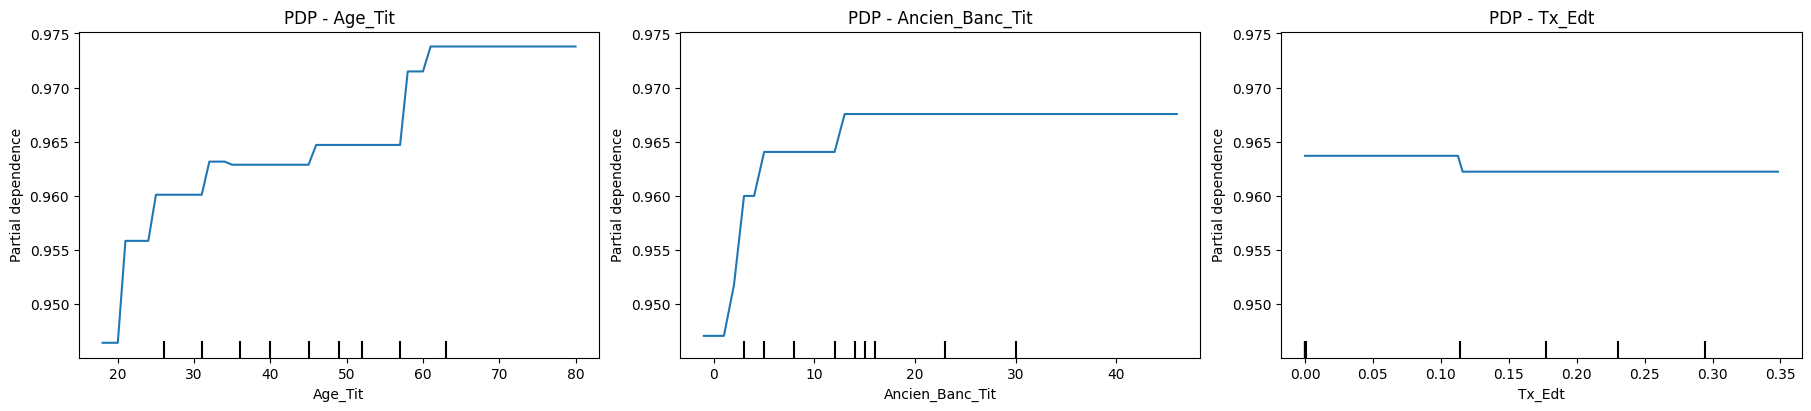

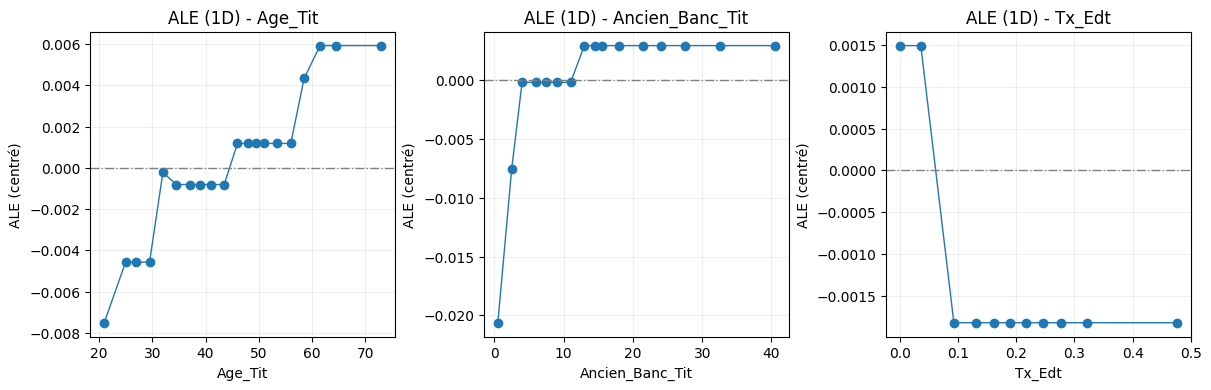

In [ ]:
from sklearn.inspection import PartialDependenceDisplay
import numpy as _np
import pandas as _pd
import matplotlib.pyplot as plt

# PDP & ALE for Age_Tit, Ancien_Banc_Tit, Tx_Edt
FEATURES_PDP = ["Age_Tit", "Ancien_Banc_Tit", "Tx_Edt"]
X_ref = X_train[var_model].copy()

# Partial Dependence Plots
fig, axes = plt.subplots(1, 3, figsize=(18, 4), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    xgb_best,
    X_ref,
    features=FEATURES_PDP,
    kind="average",
    ax=axes
)
for ax, f in zip(axes, FEATURES_PDP):
    ax.set_title(f"PDP - {f}")
plt.show()

# Accumulated Local Effects (ALE) 1D
def _predict_score(estimator, X):
    if hasattr(estimator, "predict_proba"):
        return estimator.predict_proba(X)[:, 1]
    if hasattr(estimator, "decision_function"):
        s = estimator.decision_function(X)
        try:
            return 1 / (1 + _np.exp(-_np.asarray(s, dtype=float)))
        except Exception:
            return s.astype(float)
    yhat = estimator.predict(X)
    return yhat.astype(float)

def ale_1d(estimator, X, feature, n_bins=20):
    x = _np.asarray(X[feature].values, dtype=float)
    qs = _np.linspace(0, 1, n_bins + 1)
    edges = _np.unique(_np.quantile(x, qs))
    if len(edges) < 2:
        raise ValueError(f"Error{feature}")
    mids = 0.5 * (edges[:-1] + edges[1:])
    diffs = _np.zeros(len(edges) - 1, dtype=float)
    counts = _np.zeros(len(edges) - 1, dtype=int)

    for k in range(len(edges) - 1):
        lo, hi = edges[k], edges[k + 1]
        if k == 0:
            mask = (x >= lo) & (x <= hi)
        else:
            mask = (x > lo) & (x <= hi)
        cnt = int(mask.sum())
        counts[k] = cnt
        if cnt == 0:
            continue

        X0 = X.loc[mask].copy()
        X1 = X0.copy()
        X0[feature] = lo
        X1[feature] = hi

        p0 = _predict_score(estimator, X0)
        p1 = _predict_score(estimator, X1)
        diffs[k] = float((p1 - p0).mean())
    ale_vals = _np.cumsum(diffs)
    w = counts.astype(float)
    w_sum = w.sum()
    if w_sum > 0:
        ale_center = ale_vals - (ale_vals * (w / w_sum)).sum()
    else:
        ale_center = ale_vals - ale_vals.mean()

    return _pd.DataFrame({"x": mids, "ale": ale_center, "count": counts})

# Plots ALE (Plotly)
for feat in FEATURES_PDP:
    ale_df = ale_1d(xgb_best, X_ref, feat, n_bins=20)
    fig_ale = px.line(
        ale_df,
        x="x",
        y="ale",
        title=f"ALE (1D) - {feat}",
        markers=True
    )
    fig_ale.add_hline(y=0.0, line_dash="dash", line_color="gray")
    fig_ale.update_layout(xaxis_title=feat, yaxis_title="ALE (centré)")
    fig_ale.show()

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve
THRESHOLD = 0.50
print(f"Seuil (threshold) actuel utilisé pour la décision: {THRESHOLD:.2f}")

y_score = xgb_best.predict_proba(X_test[var_model])[:, 1]
y_pred = (y_score >= THRESHOLD).astype(int)

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
cm_df = pd.DataFrame(cm, index=['Vrai 0', 'Vrai 1'], columns=['Prédit 0', 'Prédit 1'])
print("Matrice de confusion (labels: 0=Mauvais Payeur, 1=Bon Payeur):")
display(cm_df)

fpr, tpr, _ = roc_curve(y_test, y_score)
auc_val = roc_auc_score(y_test, y_score)

roc_df = pd.DataFrame({'FPR': fpr, 'TPR': tpr})
fig = px.area(
    roc_df,
    x='FPR',
    y='TPR',
    title=f"Courbe ROC - xgb_best (AUC={auc_val:.4f})",
    labels={'FPR': 'Taux de faux positifs', 'TPR': 'Taux de vrais positifs'},
    width=700,
    height=500
)
fig.add_shape(type='line', line=dict(dash='dash'), x0=0, x1=1, y0=0, y1=1)
fig.update_xaxes(range=[0, 1])
fig.update_yaxes(range=[0, 1])
fig.show()

fig_cm = px.imshow(
    cm,
    text_auto=True,
    color_continuous_scale='Blues',
    labels=dict(x='Prédit', y='Réel', color='Compte'),
    x=['0', '1'],
    y=['0', '1'],
    title=f"Matrice de confusion - xgb_best (seuil {THRESHOLD:.2f})"
)
fig_cm.update_xaxes(side='top')
fig_cm.show()

Seuil (threshold) actuel utilisé pour la décision: 0.50
Matrice de confusion (labels: 0=Mauvais Payeur, 1=Bon Payeur):


,Prédit 0,Prédit 1
Vrai 0,0,197
Vrai 1,0,5197


In [ ]:
# Choix seuil
THRESHOLD = 0.915

# Prédictions au seuil choisi
y_pred_thresh = (y_score >= THRESHOLD).astype(int)

cm = confusion_matrix(y_test, y_pred_thresh, labels=[0, 1])
cm_df = pd.DataFrame(cm, index=['Vrai 0', 'Vrai 1'], columns=['Prédit 0', 'Prédit 1'])

tn, fp, fn, tp = cm.ravel()
tpr = tp / (tp + fn) if (tp + fn) > 0 else np.nan   # sensibilité
tnr = tn / (tn + fp) if (tn + fp) > 0 else np.nan   # spécificité
prec = precision_score(y_test, y_pred_thresh)
rec = recall_score(y_test, y_pred_thresh)
auc_global = roc_auc_score(y_test, y_score)
gini_global = gini_from_auc(auc_global)

auc_at_thresh = roc_auc_score(y_test, y_pred_thresh)
gini_at_thresh = gini_from_auc(auc_at_thresh)

print(f"Seuil utilisé: {THRESHOLD:.6f}")
print(f"Sensibilité (TPR): {tpr:.6f} | Spécificité (TNR): {tnr:.6f} | "
    f"Précision: {prec:.6f} | Rappel: {rec:.6f}")
print(f"AUC (global): {auc_global:.6f} | GINI (global): {gini_global:.6f}")
print(f"AUC (au seuil): {auc_at_thresh:.6f} | GINI (au seuil): {gini_at_thresh:.6f}")

display(cm_df)

fig_cm = px.imshow(
    cm,
    text_auto=True,
    color_continuous_scale='Blues',
    labels=dict(x='Prédit', y='Réel', color='Compte'),
    x=['0', '1'],
    y=['0', '1'],
    title=f"Matrice de confusion (seuil {THRESHOLD:.6f})"
)
fig_cm.update_xaxes(side='top')
fig_cm.show()

Seuil utilisé: 0.915000
Sensibilité (TPR): 0.916490 | Spécificité (TNR): 0.329949 | Précision: 0.973034 | Rappel: 0.916490
AUC (global): 0.746255 | GINI (global): 0.492511
AUC (au seuil): 0.623220 | GINI (au seuil): 0.246440


,Prédit 0,Prédit 1
Vrai 0,65,132
Vrai 1,434,4763


### AUC / GINI / PSI

In [ ]:
y_proba_xgb = xgb_best.predict_proba(X_test)[:, 1]
y_pred_xgb = xgb_best.predict(X_test)

auc_xgb = roc_auc_score(y_test, y_proba_xgb)
gini_xgb = gini_from_auc(auc_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)

p_train_xgb = xgb_best.predict_proba(X_train)[:, 1]
psi_xgb = compute_psi(p_train_xgb, y_proba_xgb, n_bins=10)

print(f"XGB (final) - Precision: {precision_xgb:.4f} | Recall: {recall_xgb:.4f} | AUC: {auc_xgb:.4f} | GINI: {gini_xgb:.4f} | PSI: {psi_xgb:.6f}")

XGB (final) - Precision: 0.9635 | Recall: 1.0000 | AUC: 0.7463 | GINI: 0.4925 | PSI: 0.002153


### PFI Train

In [ ]:
X_pfi, y_pfi = X_train, y_train

pfi_xgb = permutation_importance(
    xgb_best,
    X_pfi,
    y_pfi,
    n_repeats=40,
    scoring="roc_auc",
    random_state=42,
    n_jobs=-1
)

q025 = np.quantile(pfi_xgb.importances, 0.025, axis=1)
q975 = np.quantile(pfi_xgb.importances, 0.975, axis=1)

pfi_xgb_df = (
    pd.DataFrame({
        "feature": X_pfi.columns,
        "importance_mean": pfi_xgb.importances_mean,
        "importance_std": pfi_xgb.importances_std,
        "q025": q025,
        "q975": q975
    })
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)

pfi_xgb_df["err_plus"] = (pfi_xgb_df["q975"] - pfi_xgb_df["importance_mean"]).clip(lower=0)
pfi_xgb_df["err_minus"] = (pfi_xgb_df["importance_mean"] - pfi_xgb_df["q025"]).clip(lower=0)

print("Permutation Feature Importance ((xgb_best), avec IC 95%) :")
display(pfi_xgb_df.round(6))

# Graphique
fig = px.bar(
    pfi_xgb_df,
    x="importance_mean",
    y="feature",
    error_x="err_plus",
    error_x_minus="err_minus",
    orientation="h",
    title="PFI (ROC AUC) - XGB (xgb_best) (IC 95%)",
    height=800
)
fig.update_layout(yaxis=dict(autorange="reversed"), xaxis_title="importance_mean")
fig.show()

Permutation Feature Importance ((xgb_best), avec IC 95%) :


,feature,importance_mean,importance_std,q025,q975,err_plus,err_minus
0,Charge,0.025253,0.003562,0.018001,0.030894,0.005640,0.007252
1,Ressource,0.022570,0.003334,0.015371,0.028043,0.005472,0.007200
2,MCLFCHAB1_P,0.020538,0.003887,0.014356,0.027871,0.007333,0.006182
3,MCLFCSITFAM_M,0.019412,0.003783,0.013765,0.026127,0.006715,0.005647
4,Age_Tit,0.018141,0.003018,0.012959,0.022793,0.004652,0.005182
5,ZCOM_SR_CL_MIMPOTS,0.017221,0.003142,0.012178,0.022856,0.005635,0.005043
6,Ancbanc_Tit,0.013395,0.002163,0.009543,0.017875,0.004479,0.003853
7,Ancien_Banc_Tit,0.013021,0.002185,0.008683,0.017101,0.004080,0.004337
8,CSP_Tit_others,0.008328,0.001046,0.005959,0.009764,0.001436,0.002369
9,Ancien_Prof_Tit,0.007028,0.001428,0.004618,0.009664,0.002636,0.002411


### PFI Test

In [50]:
X_pfi, y_pfi = X_test, y_test

pfi_xgb = permutation_importance(
    xgb_best,
    X_pfi,
    y_pfi,
    n_repeats=40,
    scoring="roc_auc",
    random_state=42,
    n_jobs=-1
)

# IC via quantiles des répétitions (axis=1 = par feature)
q025 = np.quantile(pfi_xgb.importances, 0.025, axis=1)
q975 = np.quantile(pfi_xgb.importances, 0.975, axis=1)

pfi_xgb_df = (
    pd.DataFrame({
        "feature": X_pfi.columns,
        "importance_mean": pfi_xgb.importances_mean,
        "importance_std": pfi_xgb.importances_std,
        "q025": q025,
        "q975": q975
    })
    .sort_values("importance_mean", ascending=False)
    .reset_index(drop=True)
)

# Colonnes d'erreurs (pour barres d'erreur asymétriques)
pfi_xgb_df["err_plus"] = (pfi_xgb_df["q975"] - pfi_xgb_df["importance_mean"]).clip(lower=0)
pfi_xgb_df["err_minus"] = (pfi_xgb_df["importance_mean"] - pfi_xgb_df["q025"]).clip(lower=0)

print("Permutation Feature Importance ((xgb_best), avec IC 95%) :")
display(pfi_xgb_df.round(6))

# Graphique barres avec IC 95% en erreurs asymétriques

fig = px.bar(
    pfi_xgb_df,
    x="importance_mean",
    y="feature",
    error_x="err_plus",
    error_x_minus="err_minus",
    orientation="h",
    title="PFI (ROC AUC) - XGB (xgb_best) (IC 95%)",
    height=800
)
fig.update_layout(yaxis=dict(autorange="reversed"), xaxis_title="importance_mean")
fig.show()

Permutation Feature Importance ((xgb_best), avec IC 95%) :


,feature,importance_mean,importance_std,q025,q975,err_plus,err_minus
0,MCLFCHAB1_P,0.019918,0.005650,0.009755,0.030671,0.010753,0.010164
1,Ressource,0.019116,0.005839,0.008174,0.028468,0.009352,0.010942
2,Charge,0.016445,0.006730,0.005184,0.027260,0.010815,0.011261
3,ZCOM_SR_CL_MIMPOTS,0.016028,0.005198,0.008862,0.024733,0.008706,0.007166
4,Age_Tit,0.013395,0.005280,0.002820,0.021185,0.007791,0.010575
5,Ancien_Banc_Tit,0.010793,0.002853,0.005400,0.015288,0.004495,0.005393
6,MCLFCHAB1_L,0.007976,0.003219,0.002367,0.013975,0.005999,0.005609
7,Ancbanc_Tit,0.007870,0.002793,0.002908,0.013472,0.005602,0.004962
8,Ancien_Prof_Tit,0.006273,0.001894,0.003800,0.009765,0.003493,0.002472
9,MCLFCSITFAM_M,0.005226,0.005263,-0.003234,0.014291,0.009065,0.008460


### Feature Importance XGBoost

In [ ]:
booster = xgb_best.get_booster()
feature_names = list(getattr(X_train, "columns", getattr(xgb_best, "feature_names_in_", [])))

importance_types = ["gain", "weight", "cover", "total_gain", "total_cover"]

raw = {t: pd.Series(booster.get_score(importance_type=t)) for t in importance_types}
imp_df = pd.DataFrame(raw).fillna(0.0)

if feature_names and all(idx.startswith("f") and idx[1:].isdigit() for idx in imp_df.index):
    mapping = {f"f{i}": fn for i, fn in enumerate(feature_names)}
    imp_df = imp_df.rename(index=mapping)

if feature_names:
    imp_df = imp_df.reindex(feature_names, fill_value=0.0)

try:
    sk_importance = pd.Series(xgb_best.feature_importances_, index=feature_names, name="sklearn_importance")
    imp_df = imp_df.join(sk_importance, how="left")
except Exception:
    pass

for col in imp_df.columns:
    imp_df[f"rank_{col}"] = (-imp_df[col]).argsort().argsort() + 1

imp_df = imp_df.sort_values("gain", ascending=False)

print("Top 30 features par 'gain':")
display(imp_df.head(30).round(6))

try:
    fig = px.bar(
        imp_df.head(30).reset_index().rename(columns={"index": "feature"}),
        x="gain",
        y="feature",
        orientation="h",
        title="XGBoost (xgb_best) - Feature importance (gain) - Top 30",
        height=800
    )
    fig.update_layout(yaxis=dict(autorange="reversed"))
    fig.show()
except Exception:
    pass

Top 30 features par 'gain':


,gain,weight,cover,total_gain,total_cover,sklearn_importance,rank_gain,rank_weight,rank_cover,rank_total_gain,rank_total_cover,rank_sklearn_importance
Age_Tit,24.882971,8.0,202.324188,199.063766,1618.593506,0.110985,1,2,7,1,3,1
ZCOM_SR_CL_MIMPOTS,24.485674,6.0,245.155197,146.914047,1470.931152,0.109213,2,8,4,3,6,2
Ressource,23.228661,8.0,152.173676,185.829285,1217.389404,0.103606,3,4,12,2,8,3
Ancien_Banc_Tit,20.349737,6.0,248.983719,122.098419,1493.902344,0.090766,4,7,3,4,5,4
MCLFCSITFAM_M,14.017124,6.0,289.838593,84.102745,1739.031494,0.062520,5,9,1,7,2,5
MCLFCHAB1_P,12.394040,7.0,227.264053,86.758278,1590.848389,0.055281,6,5,6,6,4,6
Mrev_Tit,10.793827,5.0,174.366302,53.969135,871.831543,0.048144,7,10,9,9,10,7
Ratio_Ress_RAV,10.399348,3.0,14.851420,31.198044,44.554260,0.046384,8,12,20,11,18,8
Ancbanc_Tit,10.159319,8.0,168.400391,81.274551,1347.203125,0.045313,9,3,11,8,7,9
Charge,8.795070,10.0,199.119629,87.950699,1991.196289,0.039229,10,1,8,5,1,10


### SHAP

c:\Users\aysim\Documents\Ynov\EpreuvesCertif\BLOC5\Octroi\score-octroi\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



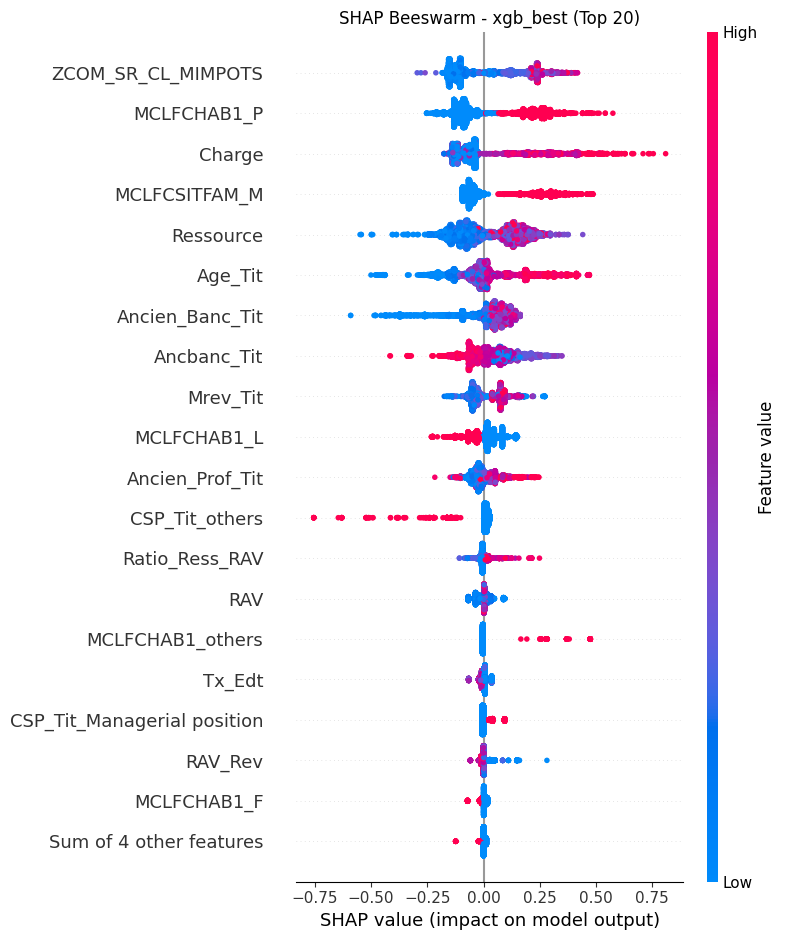

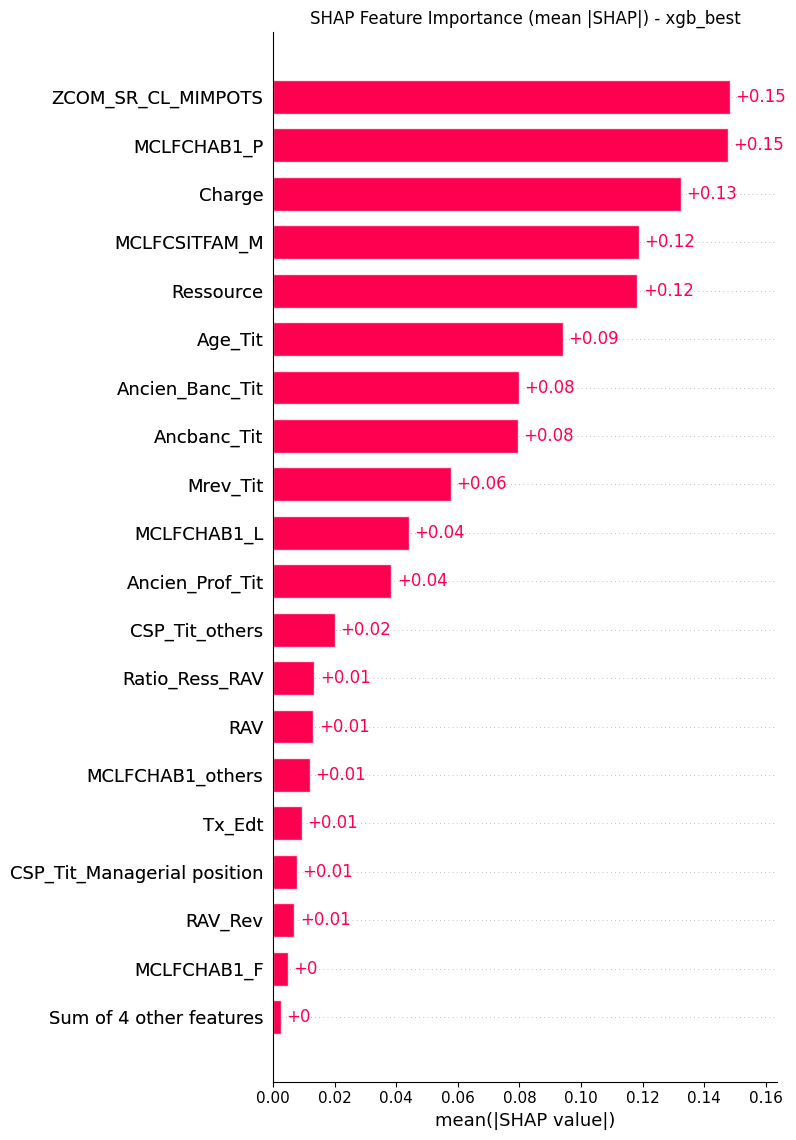

In [ ]:
import shap
import matplotlib.pyplot as plt

explainer = shap.Explainer(xgb_best, X_train)
X_shap = X_test

shap_values = explainer(X_shap)

try:
    shap.plots.beeswarm(shap_values, max_display=20, show=False)
    plt.title("SHAP Beeswarm - xgb_best (Top 20)")
    plt.tight_layout()
    plt.show()
except Exception:
    # Fallback for older SHAP versions
    shap.summary_plot(getattr(shap_values, "values", shap_values), X_shap, plot_type="dot", max_display=20, show=False)
    plt.title("SHAP summary - xgb_best (Top 20)")
    plt.tight_layout()
    plt.show()

try:
    shap.plots.bar(shap_values, max_display=20, show=False)
    plt.title("SHAP Feature Importance (mean |SHAP|) - xgb_best")
    plt.tight_layout()
    plt.show()
except Exception:
    shap.summary_plot(getattr(shap_values, "values", shap_values), X_shap, plot_type="bar", max_display=20, show=False)
    plt.title("SHAP Feature Importance - xgb_best")
    plt.tight_layout()
    plt.show()

Individu à proba la plus basse: index 12974, p=0.807099
Individu à proba la plus forte: index 11932, p=0.990677
Individu aléatoire: index 10986, p=0.964972


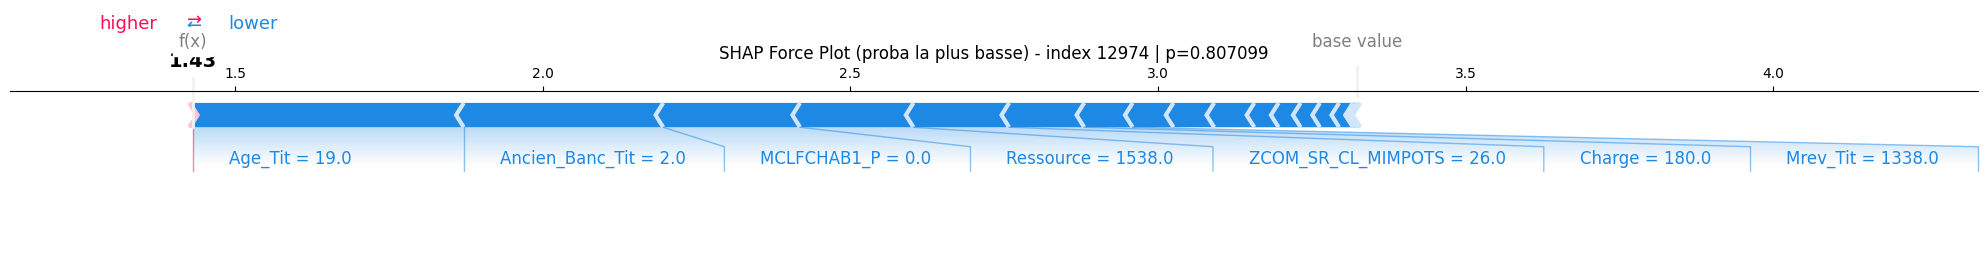

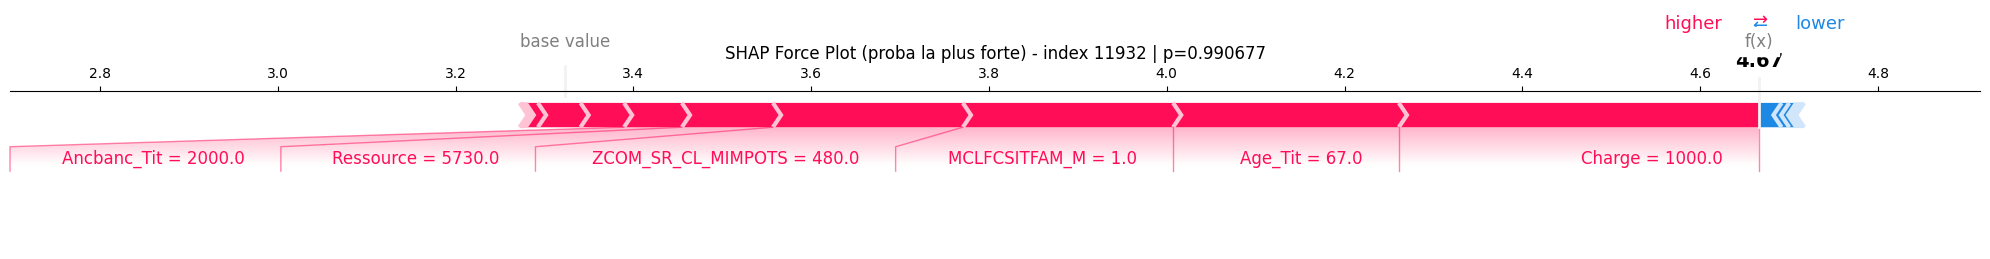

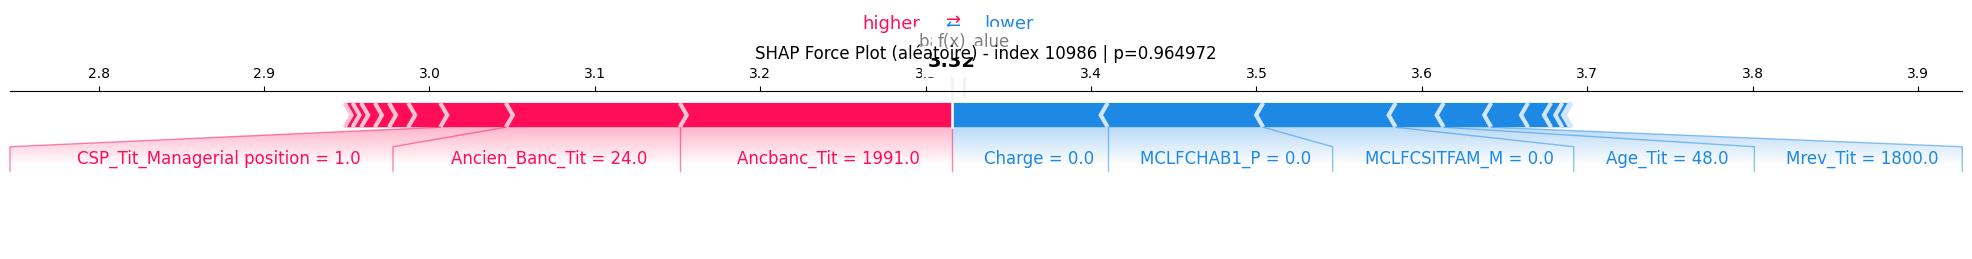

Prédictions sélectionnées + y_test (0 = Mauvais Payeur, 1 = Bon Payeur):


,index,proba,prediction,label,y_test,y_test_label
type,,,,,,
proba_min,12974,0.807099,1,Bon Payeur,1,Bon Payeur
proba_max,11932,0.990677,1,Bon Payeur,1,Bon Payeur
random,10986,0.964972,1,Bon Payeur,1,Bon Payeur


In [ ]:
from scipy.special import expit

if 'p_pred' in globals():
    proba = p_pred
elif 'y_proba_xgb' in globals():
    proba = pd.Series(y_proba_xgb, index=X_shap.index, name="p_test")
elif 'xgb_best' in globals():
    proba = pd.Series(xgb_best.predict_proba(X_shap)[:, 1], index=X_shap.index, name="p_test")
else:
    sv = getattr(shap_values, "values", shap_values)
    base = np.array(getattr(shap_values, "base_values", [shap_values.base_values] * len(X_shap))).reshape(-1)
    logit = base + sv.sum(axis=1)
    proba = pd.Series(expit(logit), index=X_shap.index, name="p_test")

idx_min = proba.idxmin()
idx_max = proba.idxmax()
rng = np.random.default_rng()
idx_rand = rng.choice(np.array(proba.index))

def _plot_force(idx_label, title_prefix=""):
    pos = X_shap.index.get_loc(idx_label)
    sv_single = shap_values[pos]
    sample = X_shap.loc[[idx_label]]

    try:
        shap.plots.force(sv_single, matplotlib=True, show=False)
        plt.title(f"{title_prefix} - index {idx_label} | p={proba.loc[idx_label]:.6f}")
        plt.tight_layout()
        plt.show()
    except Exception:
        shap.force_plot(
            getattr(sv_single, "base_values", getattr(shap_values, "base_values", None)),
            getattr(sv_single, "values", sv_single),
            sample,
            feature_names=sample.columns,
            matplotlib=True,
            show=False
        )
        plt.title(f"{title_prefix} (legacy) - index {idx_label} | p={proba.loc[idx_label]:.6f}")
        plt.tight_layout()
        plt.show()

_print_min = f"Individu à proba la plus basse: index {idx_min}, p={proba.loc[idx_min]:.6f}"
_print_max = f"Individu à proba la plus forte: index {idx_max}, p={proba.loc[idx_max]:.6f}"
_print_rand = f"Individu aléatoire: index {idx_rand}, p={proba.loc[idx_rand]:.6f}"
print(_print_min)
print(_print_max)
print(_print_rand)

_plot_force(idx_min, "SHAP Force Plot (proba la plus basse)")
_plot_force(idx_max, "SHAP Force Plot (proba la plus forte)")
_plot_force(idx_rand, "SHAP Force Plot (aléatoire)")

label_map = {0: "Mauvais Payeur", 1: "Bon Payeur"}

def _pred_for_idx(idx):
    if 'y_pred_xgb' in globals() and len(y_pred_xgb) == len(X_shap):
        pos = X_shap.index.get_loc(idx)
        return int(y_pred_xgb[pos])
    elif 'xgb_best' in globals():
        return int(xgb_best.predict(X_shap.loc[[idx]])[0])
    else:
        return int(proba.loc[idx] >= 0.5)

def _true_for_idx(idx):
    if 'y_test' in globals():
        try:
            return int(y_test.loc[idx])
        except Exception:
            pos = X_shap.index.get_loc(idx)
            return int(y_test.iloc[pos])
    return None

rows = []
for kind, idx in [("proba_min", idx_min), ("proba_max", idx_max), ("random", idx_rand)]:
    pred = _pred_for_idx(idx)
    y_true = _true_for_idx(idx)
    rows.append({
        "type": kind,
        "index": idx,
        "proba": float(proba.loc[idx]),
        "prediction": pred,
        "label": label_map[pred],
        "y_test": y_true,
        "y_test_label": label_map[y_true] if y_true is not None else None
    })

predictions_sel_df = pd.DataFrame(rows).set_index("type")
print("Prédictions sélectionnées + y_test (0 = Mauvais Payeur, 1 = Bon Payeur):")
display(predictions_sel_df)

## Save Model